In [1]:
from modules import expectedMultiBleu
import numpy as np
import torch
if torch.cuda.is_available():
    from torch.cuda import LongTensor, FloatTensor
else:
    from torch import LongTensor, FloatTensor
from torch.autograd import Variable
from torch.nn import Module, functional as F
from modules.expectedBLEU import bleu as ebleu
from modules.expectedMultiBleu import bleu, calculate_overlap
from modules.matrixBLEU import mBLEU
from matplotlib import pyplot as plt
from modules.utils import CUDA_wrapper
import time
plt.style.use('ggplot')
%matplotlib inline

# Toy experiment
Here we will implement described in article. We will try optimize $t$ matrix by minimizing expectedBLEU (see training function)

* Elements of matrix $t$ are generated by sampling logits from $N(0,1)$ and then $softmax$ function is applied row-wise to obtain probability distribution for words.
* Indexes of reference text $r$ are generated by uniform sampling with replacement from vocabulary.

In [2]:
def generate_batch_references(references_lengths, vocab_size):
    def _gen_padded_ref(l):
        ref = np.random.choice(vocab_size, size=l, replace=True)
        padding = np.array([0] * (max_len - l), dtype=int)
        return np.concatenate((ref, padding)).tolist()
    max_len = np.max(references_lengths)
    res = [_gen_padded_ref(l)\
           for l in references_lengths]
    return res

def _all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

def onehot_initialization(a, vocab_size):
    ncols = vocab_size
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[_all_idx(a, axis=2)] = 1
    return out

class MySoftmax(Module):

    def forward(self, input_):
        batch_size = input_.size()[0]
        output_ = torch.stack([F.softmax(input_[i]) for i in range(batch_size)], 0)
        return output_

In [3]:
np.random.seed(3)
torch.manual_seed(2)
class Optimization_experiment:
    def __init__(self, low_len = 8, hight_len = 10,\
                 batch_size = 1, translation_len = 10, vocab_size = 20000):
        self.batch_size = batch_size
        self.translation_len = translation_len
        self.vocab_size = vocab_size
        self.sm = MySoftmax()
        self.references_lengths = np.random.randint(low=low_len,\
                                        high=hight_len + 1, size=batch_size)
        self.t = Variable(CUDA_wrapper(\
                    torch.randn((batch_size, translation_len, vocab_size))),\
            requires_grad=True)
        self.references_batch = generate_batch_references(self.references_lengths, vocab_size)
        self.R = Variable(FloatTensor(onehot_initialization(\
                        np.array(self.references_batch), self.vocab_size).tolist()))
        self.mbl = mBLEU()
        
    def estimate_expected_bleu(self, number_of_samples):
        probs = self.sm(self.t)
        estimations = []
        for _ in range(number_of_samples):
            samples_batch = []
            for seq_probs in probs.data.cpu().numpy():
                samples = []
                for word_probs in seq_probs:
                    samples.append(np.random.multinomial(\
                            1, word_probs/np.sum(word_probs) - 1E-6))
                samples_batch.append(samples)
            samples_batch = CUDA_wrapper(\
                        torch.from_numpy(np.array(samples_batch).astype(np.float32)))
            estimation = self.mbl(self.R, Variable(samples_batch), self.references_lengths,\
                            LongTensor([self.translation_len] * self.batch_size))
            estimations.append(estimation[0].data.cpu()[0])
        return np.mean(estimations)
    
    def estimate_exact(self):
        return self.mbl(self.R, self.t, self.references_lengths,\
                        LongTensor([self.translation_len] * self.batch_size))
    
    def train(self, max_order=4, steps=100, number_of_samples=100):
        opt = torch.optim.Adam([self.t], lr=0.1)
        grad_norms = []
        bleu_lb = []
        start_time = time.time()
        estimations_ebleu = []
        exact_estimations = []
        for i in range(steps):
            probs = self.sm(self.t)
            b = bleu(probs, self.references_batch, \
                    LongTensor([self.translation_len] * self.batch_size),\
                    self.references_lengths, max_order=max_order, smooth=True)
            b[0].backward()
            b_no_smooth = bleu(probs, self.references_batch, \
                LongTensor([self.translation_len] * self.batch_size),\
                self.references_lengths, max_order=max_order, smooth=False)
            bleu_lb.append(-b_no_smooth[0].data[0])
            opt.step()
            grad_norms.append(self.t.grad.data.norm())
            estimations_ebleu.append(-self.estimate_expected_bleu(number_of_samples))
            exact_estimations.append(-self.estimate_exact()[0].data.cpu()[0])
        return exact_estimations, estimations_ebleu, bleu_lb, grad_norms
exp = Optimization_experiment(batch_size=2)

In [4]:
exact_estimations, estimations_ebleu,\
            bleu_lb, grad_norms = exp.train(steps=200,number_of_samples=20)

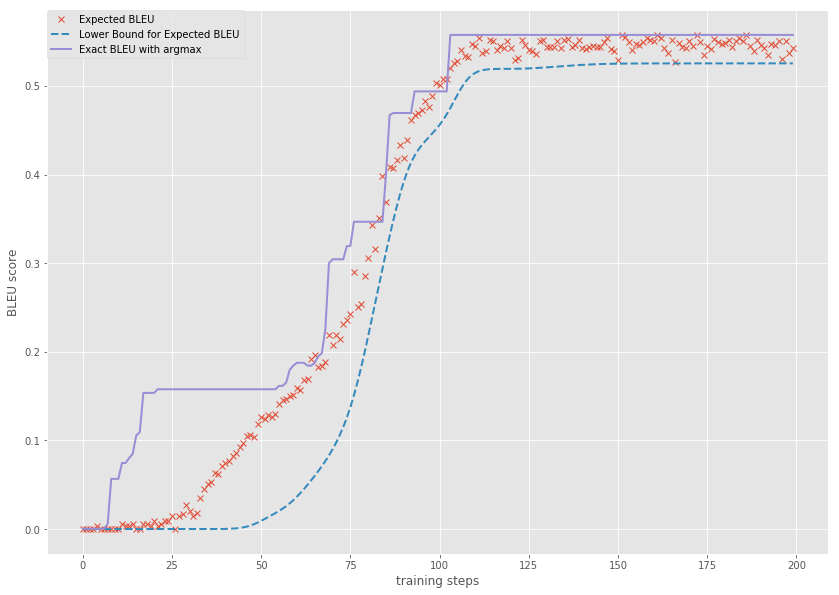

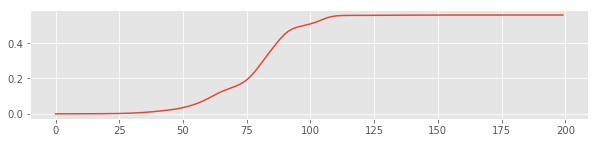

In [10]:
plt.figure(figsize=(14, 10))
plt.plot(estimations_ebleu, 'x', linewidth=6, label='Expected BLEU')
plt.plot(bleu_lb, '--', linewidth=2, label='Lower Bound for Expected BLEU')
plt.plot(exact_estimations, '-', linewidth=2, label='Exact BLEU with argmax')
plt.ylabel('BLEU score')
plt.xlabel('training steps')
plt.legend(loc=2, borderaxespad=0.)
plt.figure(figsize=(10, 2))
plt.plot(grad_norms)
plt.show()